# Results, section 2:

In [1]:
import os, sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from sklearn.impute import SimpleImputer

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_DWI/code/func/')
from proj_environment import set_proj_env
from func import mark_outliers, get_cmap, run_corr, get_fdr_p, perc_dev, evd, summarise_network

In [3]:
exclude_str = 't1Exclude'
parc_str = 'schaefer'
parc_scale = 200
primary_covariate = 'ageAtScan1'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str,
                                                                            parc_str = parc_str, parc_scale = parc_scale,
                                                                            primary_covariate = primary_covariate)

In [4]:
os.environ['NORMATIVEDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_DWI/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_200_streamlineCount/ageAtScan1+sex_adj'

In [5]:
metrics = ('ct', 'vol', 'str', 'ac', 'mc')
phenos = ('Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear',
         'F1_Exec_Comp_Res_Accuracy', 'F2_Social_Cog_Accuracy', 'F3_Memory_Accuracy', 'F1_Complex_Reasoning_Efficiency',
          'F2_Memory.Efficiency', 'F3_Executive_Efficiency', 'F4_Social_Cognition_Efficiency',)

## Setup plots

In [6]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'talk', font_scale = 1)
cmap = sns.color_palette("pastel", 3)

## Load data

In [7]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True); print(df_train.shape)
df_node_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid'], inplace = True); print(df_node_train.shape)
z_cv = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'cv/Z.txt'), delimiter = ' ').transpose()
df_z_cv = pd.DataFrame(data = z_cv, index = df_node_train.index, columns = df_node_train.columns); print(df_z_cv.shape)

# Test
df_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'test.csv'))
df_test.set_index(['bblid', 'scanid'], inplace = True); print(df_test.shape)
df_node_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_test.csv'))
df_node_test.set_index(['bblid', 'scanid'], inplace = True); print(df_node_test.shape)
z = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'Z.txt'), delimiter = ' ').transpose()
df_z_test = pd.DataFrame(data = z, index = df_node_test.index, columns = df_node_test.columns); print(df_z_test.shape)

# SMSE
smse = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node_test.columns)

(308, 47)
(308, 1000)
(308, 1000)
(760, 47)
(760, 1000)
(760, 1000)


In [8]:
df = pd.concat((df_train,df_test), axis = 0)
df_node = pd.concat((df_node_train,df_node_test), axis = 0)
df_z = pd.concat((df_z_cv,df_z_test), axis = 0)

# Characterizing the psychopathology phenotype data

Let's have a look at our psychopathology phenotype data, which are the continous DVs for our predictive model

In [9]:
print('N:', df.shape[0])

N: 1068


In [10]:
# How much missing data have I got in the phenotypes?
for pheno in phenos:
    print('No. of NaNs for ' + pheno + ':', df.loc[:,pheno].isna().sum())

No. of NaNs for Overall_Psychopathology: 0
No. of NaNs for Psychosis_Positive: 0
No. of NaNs for Psychosis_NegativeDisorg: 0
No. of NaNs for AnxiousMisery: 0
No. of NaNs for Externalizing: 0
No. of NaNs for Fear: 0
No. of NaNs for F1_Exec_Comp_Res_Accuracy: 3
No. of NaNs for F2_Social_Cog_Accuracy: 3
No. of NaNs for F3_Memory_Accuracy: 3
No. of NaNs for F1_Complex_Reasoning_Efficiency: 3
No. of NaNs for F2_Memory.Efficiency: 3
No. of NaNs for F3_Executive_Efficiency: 3
No. of NaNs for F4_Social_Cognition_Efficiency: 3


In [11]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [12]:
imputer.fit(df.loc[:,phenos])
df.loc[:,phenos] = imputer.transform(df.loc[:,phenos])

In [13]:
# How much missing data have I got in the phenotypes?
for pheno in phenos:
    print('No. of NaNs for ' + pheno + ':', df.loc[:,pheno].isna().sum())

No. of NaNs for Overall_Psychopathology: 0
No. of NaNs for Psychosis_Positive: 0
No. of NaNs for Psychosis_NegativeDisorg: 0
No. of NaNs for AnxiousMisery: 0
No. of NaNs for Externalizing: 0
No. of NaNs for Fear: 0
No. of NaNs for F1_Exec_Comp_Res_Accuracy: 0
No. of NaNs for F2_Social_Cog_Accuracy: 0
No. of NaNs for F3_Memory_Accuracy: 0
No. of NaNs for F1_Complex_Reasoning_Efficiency: 0
No. of NaNs for F2_Memory.Efficiency: 0
No. of NaNs for F3_Executive_Efficiency: 0
No. of NaNs for F4_Social_Cognition_Efficiency: 0


In [14]:
# my_bool = df.loc[:,phenos].isna().any(axis = 1)

# df = df.loc[~my_bool,:]
# df_node = df_node.loc[~my_bool,:]
# df_z = df_z.loc[~my_bool,:]

# print('N:', df.shape[0])

In [15]:
df.columns

Index(['squeakycleanExclude', 'ageAtScan1', 'ageAtScan1_Years', 'sex', 'race2',
       'handednessv2', 'dti64MeanAbsRMS', 'dti64MeanRelRMS', 'dti64MaxAbsRMS',
       'dti64MaxRelRMS', 'mprage_antsCT_vol_TBV', 'averageManualRating',
       'Overall_Psychopathology', 'Psychosis_Positive',
       'Psychosis_NegativeDisorg', 'AnxiousMisery', 'Externalizing', 'Fear',
       'Overall_Efficiency', 'Overall_Accuracy', 'Overall_Speed',
       'F1_Exec_Comp_Res_Accuracy', 'F2_Social_Cog_Accuracy',
       'F3_Memory_Accuracy', 'F1_Complex_Reasoning_Efficiency',
       'F2_Memory.Efficiency', 'F3_Executive_Efficiency',
       'F4_Social_Cognition_Efficiency', 'F1_Slow_Speed', 'F2_Fast_Speed',
       'F3_Memory_Speed', 'Overall_Efficiency_Ar', 'Overall_Accuracy_Ar',
       'Overall_Speed_Ar', 'F1_Exec_Comp_Cog_Accuracy_Ar',
       'F2_Social_Cog_Accuracy_Ar', 'F3_Memory_Accuracy_Ar',
       'F1_Social_Cognition_Efficiency_Ar',
       'F2_Complex_Reasoning_Efficiency_Ar', 'F3_Memory_Efficiency_Ar',


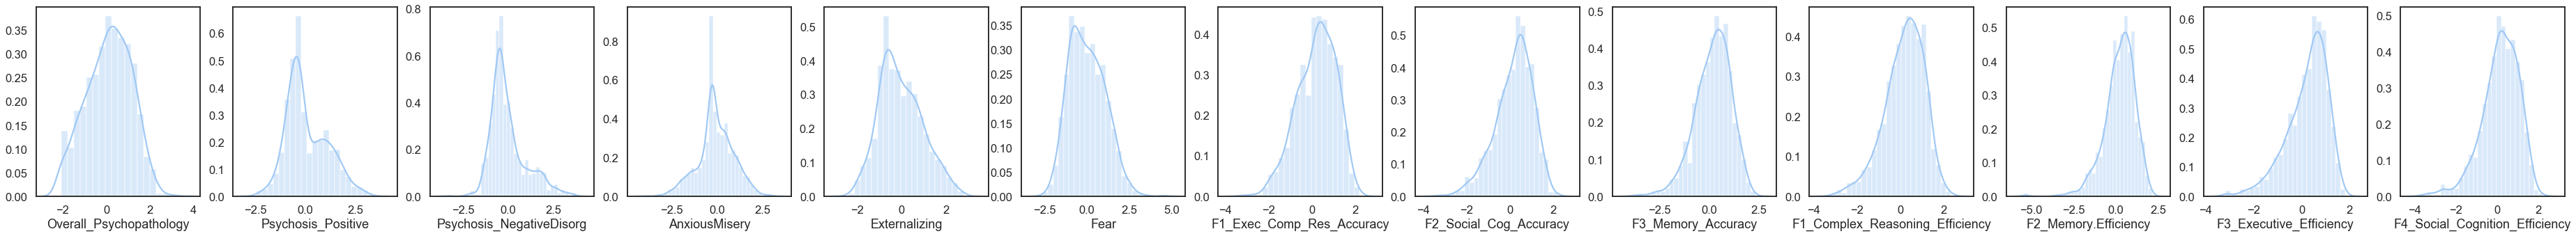

In [16]:
f, ax = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*5)
f.set_figheight(5)

if len(phenos) == 1:
    sns.distplot(df.loc[:,phenos[0]], ax = ax, color = cmap[0])
    ax.set_xlabel(phenos[0])
else:
    for i, pheno in enumerate(phenos):
        sns.distplot(df.loc[:,pheno], ax = ax[i], color = cmap[0])
        ax[i].set_xlabel(pheno)     

In [17]:
for pheno in phenos:
    df.loc[:,pheno] = sp.stats.yeojohnson(df.loc[:,pheno])[0]
#     df.loc[:,pheno] = np.log(df.loc[:,pheno] + (df.loc[:,pheno].abs().max()+1))
#     df.loc[:,pheno] = (df.loc[:,pheno] - df.loc[:,pheno].mean())/df.loc[:,pheno].std()  

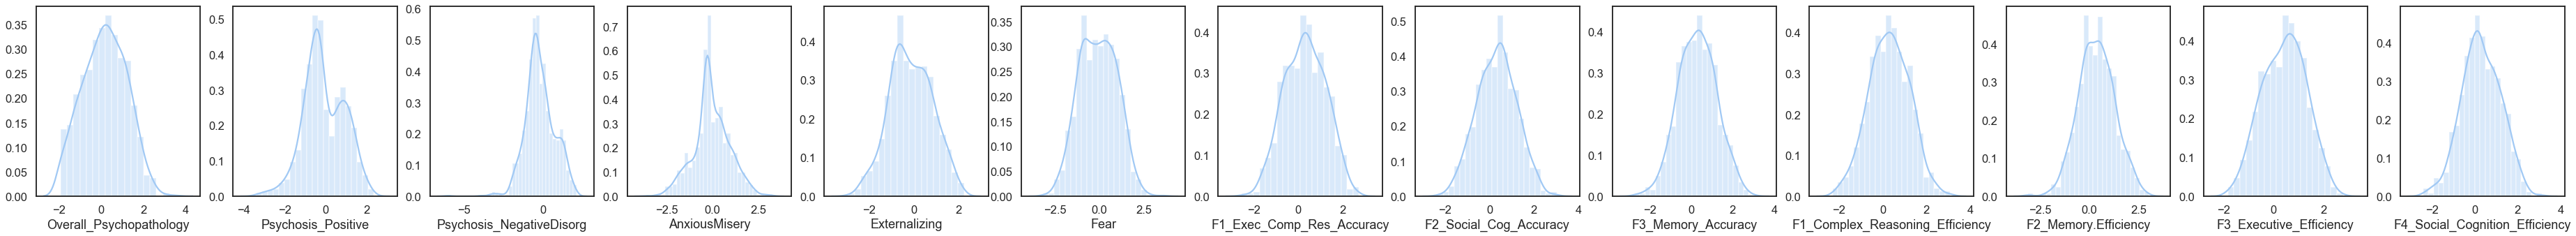

In [18]:
f, ax = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*5)
f.set_figheight(5)

if len(phenos) == 1:
    sns.distplot(df.loc[:,phenos[0]], ax = ax, color = cmap[0])
    ax.set_xlabel(phenos[0])
else:
    for i, pheno in enumerate(phenos):
        sns.distplot(df.loc[:,pheno], ax = ax[i], color = cmap[0])
        ax[i].set_xlabel(pheno)     

### Regress age/sex out of DVs

In [19]:
df_nuis = df.loc[:,[primary_covariate,'sex_adj']]
df_nuis = sm.add_constant(df_nuis)

# phenos
mdl = sm.OLS(df.loc[:,phenos], df_nuis).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = phenos
df.loc[:,phenos] = df.loc[:,phenos] - y_pred

# # df_node
# cols = df_node.columns
# mdl = sm.OLS(df_node.loc[:,cols], df_nuis).fit()
# y_pred = mdl.predict(df_nuis)
# y_pred.columns = cols
# df_node.loc[:,cols] = df_node.loc[:,cols] - y_pred

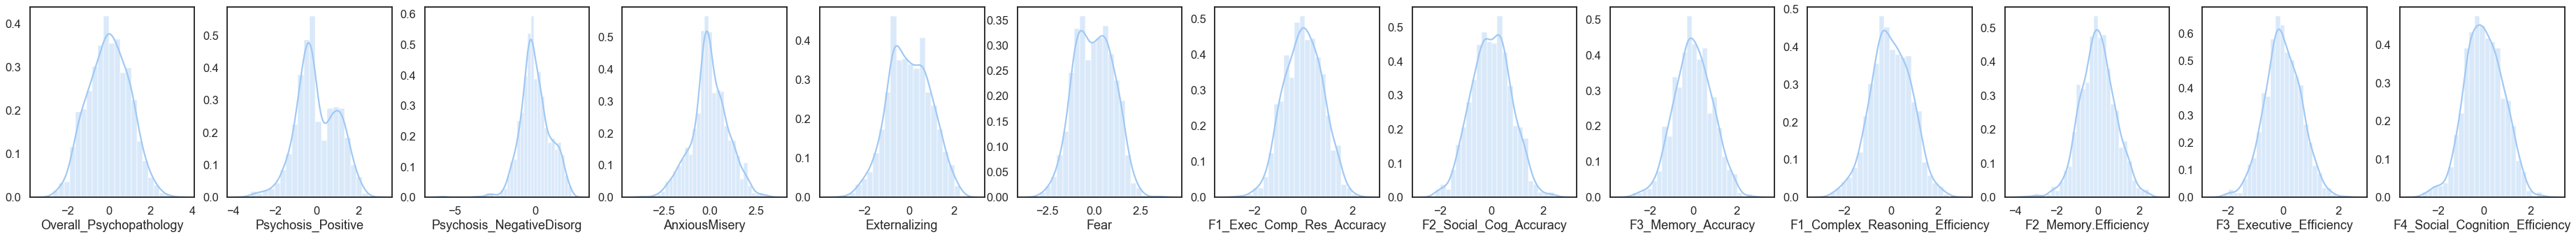

In [20]:
f, ax = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*5)
f.set_figheight(5)

if len(phenos) == 1:
    sns.distplot(df.loc[:,phenos[0]], ax = ax, color = cmap[0])
    ax.set_xlabel(phenos[0])
else:
    for i, pheno in enumerate(phenos):
        sns.distplot(df.loc[:,pheno], ax = ax[i], color = cmap[0])
        ax[i].set_xlabel(pheno)     

In [21]:
df.loc[:,phenos].head()

,,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear,F1_Exec_Comp_Res_Accuracy,F2_Social_Cog_Accuracy,F3_Memory_Accuracy,F1_Complex_Reasoning_Efficiency,F2_Memory.Efficiency,F3_Executive_Efficiency,F4_Social_Cognition_Efficiency
bblid,scanid,,,,,,,,,,,,,
81287,2738,-0.299138,-1.085362,-0.359847,1.121280,1.334846,-0.278210,1.460351,0.501074,1.925573,1.280139,0.855550,0.201670,0.627099
81903,2749,-0.006288,-0.800908,0.391998,1.968150,-0.600899,-2.246917,1.502529,0.822096,1.485107,1.816413,1.981041,0.365497,0.965876
81043,2750,-1.010197,-0.642599,-0.673930,-2.088607,0.262906,-0.826332,-0.235794,-0.126226,-1.098328,-0.361977,-0.131353,-0.257204,0.496898
83080,2792,-0.358314,0.085013,1.667728,0.402145,1.853544,-0.653415,0.028264,0.586555,0.554295,0.596311,1.338279,-0.424195,0.971274
83103,2795,0.562683,-1.039521,-0.740853,-0.762797,0.314441,1.218887,-0.012691,0.681161,1.246421,-1.386257,-0.164869,0.038409,0.180388


In [22]:
for i, pheno in enumerate(phenos):
    x = df.loc[:,pheno]
    my_med = np.median(x)
    mad = np.median(abs(x - my_med))/1.4826
    print(mad)

0.48278865059940906
0.45556138420584535
0.3540229470315008
0.38659841112024623
0.4656581772040581
0.5320805672034968
0.37669563046673904
0.34838995610246
0.39970630388582484
0.40394767843744767
0.36724873192659546
0.28941522371240974
0.3917239896498989


# Feature selection

### Normative model performance

In [23]:
smse_thresh = 1
smse_filter = df_smse.values < smse_thresh
smse_filter = smse_filter.reshape(-1)
smse_filter.sum()

677

Combine all the filters into one

In [24]:
# region_filter = np.logical_and(age_filter,smse_filter)
region_filter = smse_filter
region_filter.sum()

677

In [25]:
print('regions per metric')
for metric in metrics:
    print(metric + ': ' + str(df_z.loc[:,region_filter].filter(regex = metric).shape[1]))

regions per metric
ct: 179
vol: 194
str: 64
ac: 102
mc: 138


In [26]:
df.loc[:,phenos].to_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df.csv'))
df_node.loc[:,region_filter].to_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_node.csv'))
df_z.loc[:,region_filter].to_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_z.csv'))

# Feature summaries

Alternatively could be to collapse over brain regions into single summary measures. There are a few obvious ways to do this: mean, extreme value stats. Let's look at a few!

In [27]:
df_node_summary = pd.DataFrame(index = df_node.index)
for metric in metrics:
    df_node_summary[metric+'_node_mean'] = df_node.loc[:,region_filter].filter(regex = metric, axis = 1).mean(axis = 1)
    df_node_summary[metric+'_z_mean'] = df_z.loc[:,region_filter].filter(regex = metric, axis = 1).mean(axis = 1)
    df_node_summary[metric+'_z_evd_pos'] = evd(df_z.loc[:,region_filter].filter(regex = metric, axis = 1), sign = 'pos')
    df_node_summary[metric+'_z_evd_neg'] = evd(df_z.loc[:,region_filter].filter(regex = metric, axis = 1), sign = 'neg')

In [28]:
my_bool = df_node_summary.isna().any()
my_bool

ct_node_mean     False
ct_z_mean        False
ct_z_evd_pos     False
ct_z_evd_neg     False
vol_node_mean    False
vol_z_mean       False
vol_z_evd_pos    False
vol_z_evd_neg    False
str_node_mean    False
str_z_mean       False
str_z_evd_pos     True
str_z_evd_neg     True
ac_node_mean     False
ac_z_mean        False
ac_z_evd_pos     False
ac_z_evd_neg     False
mc_node_mean     False
mc_z_mean        False
mc_z_evd_pos     False
mc_z_evd_neg     False
dtype: bool

In [29]:
df_node_summary = df_node_summary.loc[:,~my_bool]

In [30]:
df_node_summary.head()

,,ct_node_mean,ct_z_mean,ct_z_evd_pos,ct_z_evd_neg,vol_node_mean,vol_z_mean,vol_z_evd_pos,vol_z_evd_neg,str_node_mean,str_z_mean,ac_node_mean,ac_z_mean,ac_z_evd_pos,ac_z_evd_neg,mc_node_mean,mc_z_mean,mc_z_evd_pos,mc_z_evd_neg
bblid,scanid,,,,,,,,,,,,,,,,,,
81287,2738,-0.251604,-0.155890,1.659080,-1.818761,30.073482,0.473590,2.782317,-1.472719,0.689681,-0.009746,0.091060,0.072639,2.288969,-1.035245,0.002779,0.164164,1.553375,-1.866495
81903,2749,-0.087363,0.185738,2.537911,-1.880698,-546.673941,-0.742345,2.504702,-2.887628,1.217480,-0.303316,-0.055803,-0.554435,1.260746,-1.187049,0.008285,0.477434,1.561926,-1.918191
81043,2750,0.037797,0.673821,3.805713,-1.539512,-464.637858,-0.438706,3.002479,-2.588135,2.418934,0.334120,-0.081872,-0.232753,1.508809,-1.015336,0.005374,0.121505,1.519638,-2.464991
83080,2792,-0.192518,-0.146203,2.677232,-2.112613,16.949770,0.413015,3.260514,-1.604997,-0.122956,-0.004665,0.123009,0.504546,2.501281,-0.887049,-0.007181,-0.688892,1.260265,-2.441342
83103,2795,0.039537,0.199500,2.705953,-1.882719,-270.117240,-0.853879,1.350949,-2.656934,2.252742,-0.138252,-0.052951,-0.734357,1.782354,-1.496282,0.010428,0.798399,1.902581,-1.584476


In [31]:
df_node_summary.to_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_node_summary.csv'))

How do the summaries relate?

In [32]:
R = pd.DataFrame(index = df_node_summary.columns, columns = df_node_summary.columns)

for i_col in df_node_summary.columns:
    for j_col in df_node_summary.columns:
        R.loc[i_col,j_col] = sp.stats.pearsonr(df_node_summary[i_col],df_node_summary[j_col])[0]

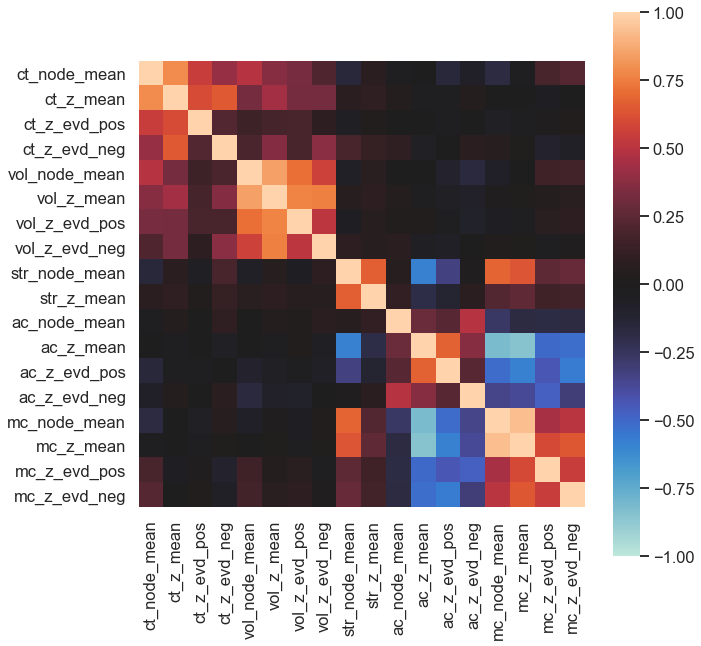

In [33]:
f, ax = plt.subplots(1)
f.set_figwidth(10)
f.set_figheight(10)

sns.heatmap(R.astype(float), annot = False, center = 0, vmax = 1, vmin = -1, ax = ax, square = True)